In [1]:
%load_ext autoreload
%autoreload 

In [2]:
from result_saver import SaverProvider, metadata_helper, metadata_loader
from soft_info.UnionFind import get_counts
import pandas as pd
import numpy as np

# Generate data

In [3]:
provider = SaverProvider()
backend = provider.get_backend('ibmq_manila')

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

qc = QuantumCircuit(1, 1)
qc.x(0)
qc.measure(0, 0)
print(qc.draw(fold=-1))

initial_layout = [0]
transpiled_qc = transpile(qc, backend, initial_layout=initial_layout, optimization_level=0)

print(transpiled_qc.draw(fold=-1))

     ┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 
               ┌───┐┌─┐
      q_0 -> 0 ┤ X ├┤M├
               └───┘└╥┘
ancilla_0 -> 1 ──────╫─
                     ║ 
ancilla_1 -> 2 ──────╫─
                     ║ 
ancilla_2 -> 3 ──────╫─
                     ║ 
ancilla_3 -> 4 ──────╫─
                     ║ 
          c: 1/══════╩═
                     0 


job_metadata = metadata_helper(sampled_state=1, num_qubits=1)
job_id = backend.run(job_metadata, transpiled_qc, shots=1e6, meas_level=1, meas_return='single').job_id()

# KDE Fitting

In [6]:
memories = {}

for job_id, sampled_s in zip(filtered_data.job_id, filtered_data.sampled_state):
    job = provider.retrieve_job(job_id)
    name = f"memory_{int(sampled_s)}_state"
    memories[name] = job.result().get_memory()

memories

{'memory_1_state': array([[ 13056256.-28170030.j],
        [ 13009988.-30052476.j],
        [ 24301122.-34140467.j],
        ...,
        [-11841316.-26943650.j],
        [ 18260363.-43577543.j],
        [ 32649675.-37288473.j]]),
 'memory_0_state': array([[-24905016.-19712283.j],
        [-15529562.-28771109.j],
        [-22304150.-31635795.j],
        ...,
        [-24769099.-26568381.j],
        [ -9517937.-27805681.j],
        [ -7834668.-43302056.j]]),
 'memory_11_state': array([[ 39336276.-5.80343120e+07j,  35651180.-2.13073650e+07j],
        [-21155615.+2.23481200e+07j,   2396680.-4.34121050e+07j],
        [ 58311299.-6.99214350e+07j,   4777609.-5.49934610e+07j],
        ...,
        [ 38365813.-9.75613090e+07j,  47176031.-2.18815880e+07j],
        [ 58786118.-1.03008886e+08j,   3275578.-5.38754450e+07j],
        [ 54067954.-4.28352180e+07j, -25826251.-6.54351190e+07j]])}

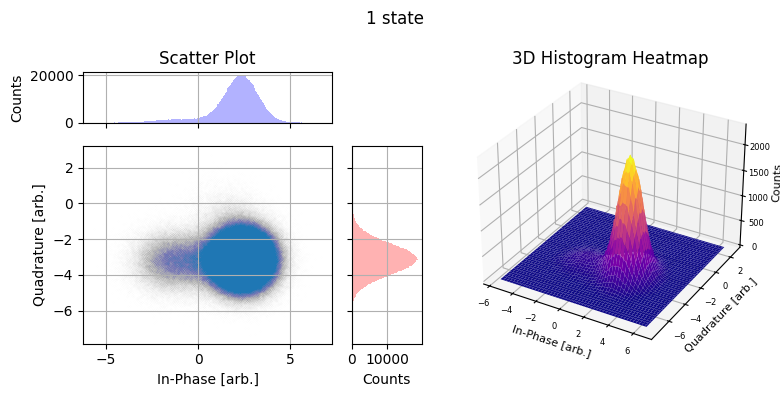

(1000000, 2)


In [74]:
from sklearn.neighbors import KernelDensity
from soft_info import plot_IQ_data

data = memories['memory_1_state']*1e-7
data = data[:int(1e6)]
plot_IQ_data(data, title='1 state')

data = data.flatten()

# Create an array of shape (N, 2) to hold the real and imaginary parts
combined_data = np.column_stack((data.real, data.imag))
print(combined_data.shape)



In [75]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(combined_data)
normalized_data = combined_data


In [102]:
# Perform 2D KDE
kde = KernelDensity(kernel='gaussian', bandwidth=70).fit(combined_data)

In [103]:
X_samle = np.array([[1, -3], [1, 3], [2,-3]])
log_proba_dens_func = kde.score_samples(X_samle)
proba_dens_func = np.exp(kde.score_samples(X_samle))
print("log_proba_dens_func:", log_proba_dens_func)
print("proba_dens_func:", proba_dens_func)


log_proba_dens_func: [-10.33524181 -10.3390304  -10.33513252]
proba_dens_func: [3.24684468e-05 3.23456699e-05 3.24719953e-05]


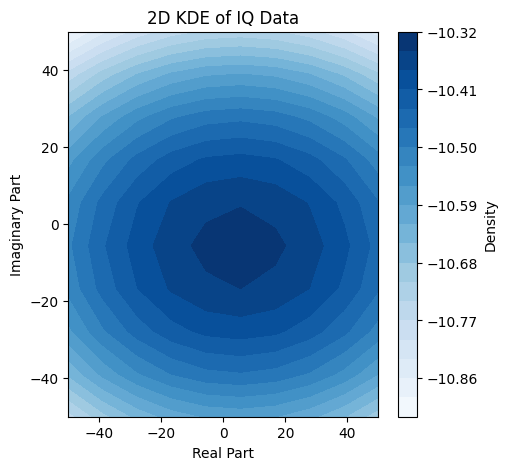

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data points for plotting (change range and grid size as needed)
x = np.linspace(min(data.real), max(data.real), 100)
y = np.linspace(min(data.imag), max(data.imag), 100)
x = np.linspace(-50, 50, 10)
y = np.linspace(-50, 50, 10)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.ravel(), Y.ravel()])
normalized_XY_grid = scaler.transform(XY)

# Evaluate density at grid points
Z = (kde.score_samples(normalized_XY_grid)).reshape(X.shape)

# Plotting
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, Z, levels=20, cmap="Blues")
plt.colorbar(label="Density")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("2D KDE of IQ Data")
plt.show()
